## Polytope Climate-DT AOI example notebook

This notebook shows how to use earthkit-data and earthkit-plots to pull destination-earth data from LUMI and plot it using earthkit-plots.

It also shows how to cut-out an area of interest using earthkit-transforms and perform some calculations upon that data.

Before running the notebook you need to set up your credentials. See the main readme of this repository for different ways to do this or use the following cells to authenticate.

You will need to generate your credentials using the desp-authentication.py script.

This can be run as follows:

In [30]:
%%capture cap
%run ../desp-authentication.py

Exception: File `'../desp-authentication.py'` not found.

This will generate a token that can then be used by earthkit and polytope.

In [31]:
output_1 = cap.stdout.split('}\n')
access_token = output_1[-1][0:-1]

# Requirements
To run this notebook install the following:
* pip install earthkit-data
* pip install earthkit-plots
* pip install earthkit-transforms
* pip install earthkit-regrid
* pip install cf-units         (Optional for unit conversion in plots)
* pip install matplotlib.pyplot

If you do not have eccodes installed please install eccodes using conda as it is a dependency of earthkit, or install earthkit via conda

* conda install eccodes -c conda-forge
* conda install earthkit-data -c conda-forge

In [32]:
import earthkit.data
import earthkit.plots
import earthkit.regrid
from earthkit.transforms import aggregate as ek_aggregate

from earthkit.data.testing import earthkit_remote_test_data_file
import earthkit.plots.quickmap as qmap
import matplotlib.pyplot as plt
from polytope.api import Client

In [33]:
a=1

In [34]:
client = Client(
    address="polytope.lumi.apps.dte.destination-earth.eu")

request = {
    'activity': 'ScenarioMIP',
    'class': 'd1',
    'dataset': 'climate-dt',
    'date': '20200102',
    'experiment': 'SSP3-7.0',
    'expver': '0001',
    'generation': '1',
    'levtype': 'sfc',
    'model': 'IFS-NEMO',
    'param': '134/165/166/167',
    'realization': '1',
    'resolution': 'standard',
    'stream': 'clte',
    'time': '0100', # '0100/0200/0300/0400/0500/0600'
    'type': 'fc'
}

files = client.retrieve("destination-earth", request, "data/climate-dt-earthkit-aoi-example.grib") 

DEBUG:polytope.api.Client.YJROGC:Gathered Polytope client configuration:
{'address': 'polytope.lumi.apps.dte.destination-earth.eu',
 'insecure': False,
 'key_path': PosixPath('/Users/maes/.polytopeapirc'),
 'log_file': None,
 'log_level': 'DEBUG',
 'password': None,
 'port': None,
 'quiet': False,
 'skip_tls': False,
 'user_email': 'alice.sartorimonteirodebarros@ecmwf.int',
 'user_key': 'fd107a37bfb422bae0720ac8d68d0219',
 'username': 'maes',
 'verbose': False}
DEBUG:polytope.api.Client.YJROGC:Creating Polytope client...
2025-06-30 09:45:53 - INFO - Sending request...
{'request': 'activity: ScenarioMIP\n'
            'class: d1\n'
            'dataset: climate-dt\n'
            "date: '20200102'\n"
            'experiment: SSP3-7.0\n'
            "expver: '0001'\n"
            "generation: '1'\n"
            'levtype: sfc\n'
            'model: IFS-NEMO\n'
            'param: 134/165/166/167\n'
            "realization: '1'\n"
            'resolution: standard\n'
            'stream: c

In [35]:
data = earthkit.data.from_source("file", "data/climate-dt-earthkit-aoi-example.grib")

In [36]:
data.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,sp,surface,0,20200102,100,0,fc,None,healpix
1,ecmf,10u,heightAboveGround,10,20200102,100,0,fc,None,healpix
2,ecmf,10v,heightAboveGround,10,20200102,100,0,fc,None,healpix
3,ecmf,2t,heightAboveGround,2,20200102,100,0,fc,None,healpix


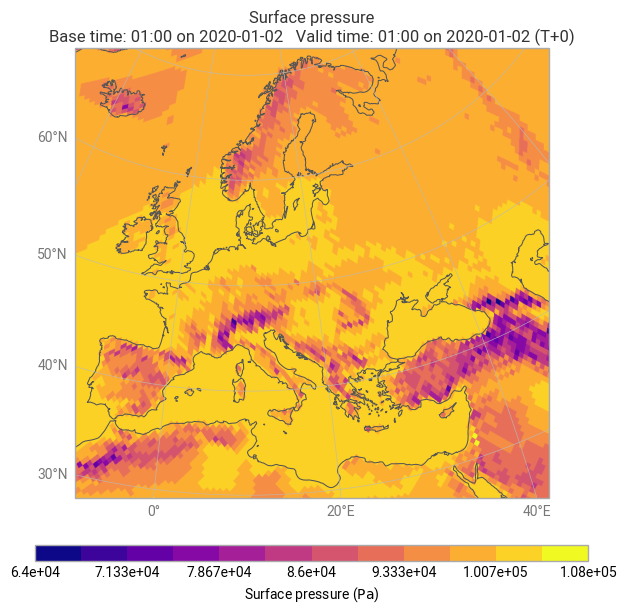

In [37]:
qmap.block(data[0], domain="Europe")

In [38]:
# Regrid t=from healpix for conversion to xarray
data_latlon = earthkit.regrid.interpolate(data, out_grid={"grid": [0.1,0.1]}, method="linear")
# Convert data to xarray
xarr = data_latlon[3].to_xarray()
xarr

<xarray.Dataset> Size: 52MB
Dimensions:    (latitude: 1801, longitude: 3600)
Coordinates:
  * latitude   (latitude) float64 14kB 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * longitude  (longitude) float64 29kB 0.0 0.1 0.2 0.3 ... 359.7 359.8 359.9
Data variables:
    2t         (latitude, longitude) float64 52MB ...
Attributes:
    param:        2t
    paramId:      167
    class:        d1
    stream:       clte
    levtype:      sfc
    type:         fc
    expver:       0001
    date:         20200102
    time:         100
    Conventions:  CF-1.8
    institution:  ECMWF

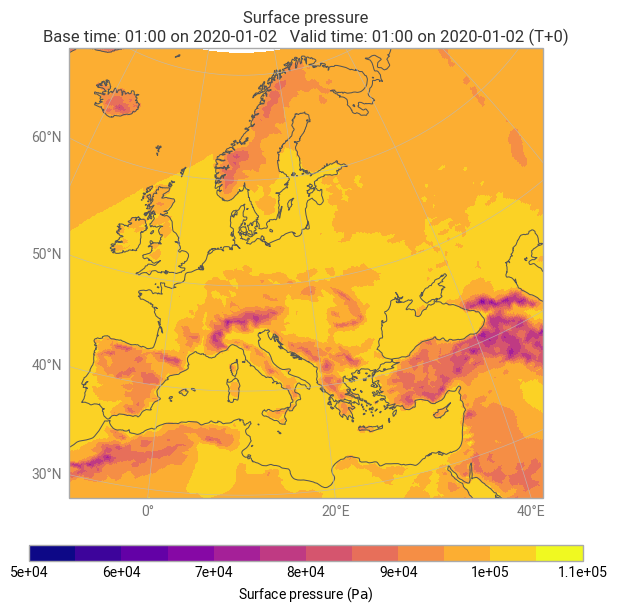

In [39]:
qmap.block(data_latlon[0], domain="Europe")

Here we pull shape files for masking of our area of interest

In [40]:
# remote_nuts_url = earthkit_remote_test_data_file("test-data", "NUTS_RG_60M_2021_4326_LEVL_0.geojson")
# nuts_data = earthkit.data.from_source("url", remote_nuts_url)
# nuts_data.save("data/NUTS_RG_60M_2021_4326_LEVL_0.geojson")

nuts_data = earthkit.data.from_source("file", "data/NUTS_RG_60M_2021_4326_LEVL_0.geojson")

In [41]:
nuts_data.to_pandas()[:5]

,id,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
0,DK,DK,0,DK,Danmark,Danmark,0,0,0,DK,"MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996..."
1,RS,RS,0,RS,Serbia,Srbija/Сpбија,0,0,0,RS,"POLYGON ((21.4792 45.193, 21.3585 44.8216, 22...."
2,EE,EE,0,EE,Eesti,Eesti,0,0,0,EE,"MULTIPOLYGON (((27.357 58.7871, 27.6449 57.981..."
3,EL,EL,0,EL,Elláda,Ελλάδα,0,0,0,EL,"MULTIPOLYGON (((28.0777 36.1182, 27.8606 35.92..."
4,ES,ES,0,ES,España,España,0,0,0,ES,"MULTIPOLYGON (((4.391 39.8617, 4.1907 39.7981,..."


`spatial.mask` applies all the features in the geometry object (`nuts_data`) to the data object (`xarr`). It returns an xarray object the same shape and type as the input xarray object with all points outside of the geometry masked.

In [42]:
single_masked_data = ek_aggregate.spatial.mask(xarr, nuts_data)
single_masked_data

<xarray.Dataset> Size: 52MB
Dimensions:    (latitude: 1801, longitude: 3600)
Coordinates:
  * latitude   (latitude) float64 14kB 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * longitude  (longitude) float64 29kB 0.0 0.1 0.2 0.3 ... 359.7 359.8 359.9
Data variables:
    2t         (latitude, longitude) float64 52MB nan nan nan ... nan nan nan
Attributes:
    param:        2t
    paramId:      167
    class:        d1
    stream:       clte
    levtype:      sfc
    type:         fc
    expver:       0001
    date:         20200102
    time:         100
    Conventions:  CF-1.8
    institution:  ECMWF

We can now plot the original data against our masked data

(35.0, 70.0)

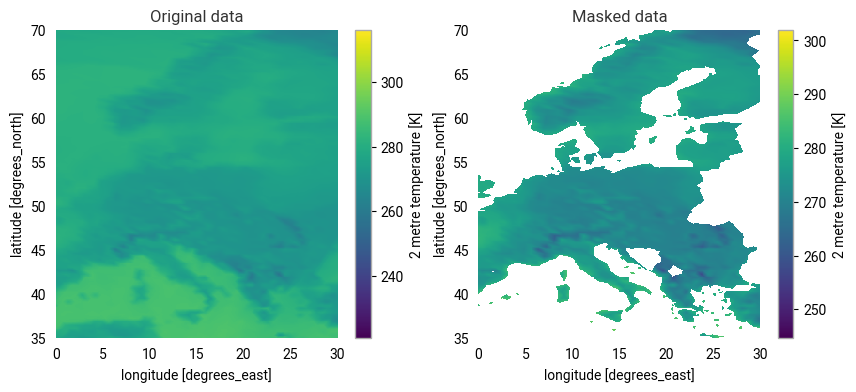

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
xarr["2t"].plot(ax=axes[0])
axes[0].set_title('Original data')
axes[0].set_xlim([0, 30])  # Longitude range for Europe
axes[0].set_ylim([35, 70])   # Latitude range for Europe
# Single masked data
single_masked_data["2t"].plot(ax=axes[1])
axes[1].set_title('Masked data')
axes[1].set_xlim([0, 30])  # Longitude range for Europe
axes[1].set_ylim([35, 70])   # Latitude range for Europe


We can further mask to only get the data for a given country.

In [44]:
masked_data = ek_aggregate.spatial.masks(xarr, nuts_data, mask_dim="FID")
masked_data

<xarray.Dataset> Size: 2GB
Dimensions:    (FID: 37, latitude: 1801, longitude: 3600)
Coordinates:
  * latitude   (latitude) float64 14kB 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * longitude  (longitude) float64 29kB 0.0 0.1 0.2 0.3 ... 359.7 359.8 359.9
  * FID        (FID) object 296B 'DK' 'RS' 'EE' 'EL' ... 'CY' 'CZ' 'DE' 'NO'
Data variables:
    2t         (FID, latitude, longitude) float64 2GB dask.array<chunksize=(1, 1801, 3600), meta=np.ndarray>
Attributes:
    param:        2t
    paramId:      167
    class:        d1
    stream:       clte
    levtype:      sfc
    type:         fc
    expver:       0001
    date:         20200102
    time:         100
    Conventions:  CF-1.8
    institution:  ECMWF

Here we only retrieve data for Germany, and plot.

Text(0.5, 1.0, 'Masked Germany Zoom')

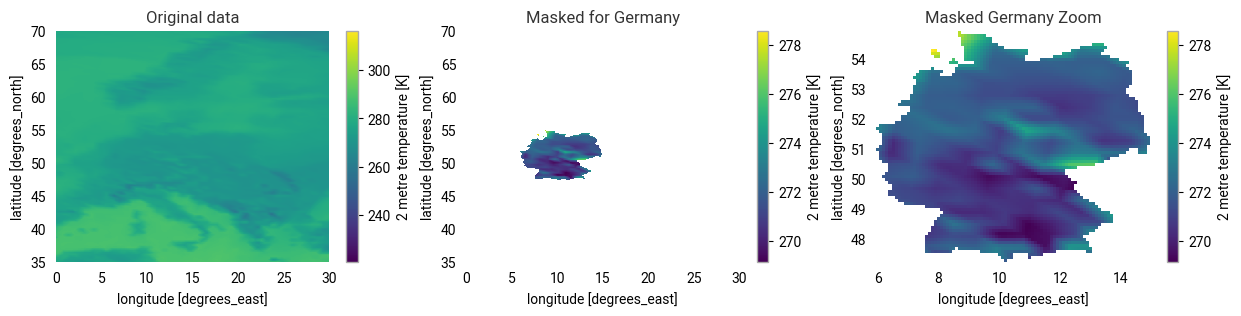

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(15,3))
xarr["2t"].plot(ax=axes[0])
axes[0].set_title('Original data')
axes[0].set_xlim([0, 30])  # Longitude range for Europe
axes[0].set_ylim([35, 70])   # Latitude range for Europe
masked_data["2t"].sel(FID='DE').plot(ax=axes[1])
axes[1].set_title('Masked for Germany')
axes[1].set_xlim([0, 30])  # Longitude range for Europe
axes[1].set_ylim([35, 70])   # Latitude range for Europe
germany_data = masked_data.sel(FID='DE').dropna(dim='latitude', how='all').dropna(dim='longitude', how='all')
germany_data["2t"].plot(ax=axes[2])
axes[2].set_title('Masked Germany Zoom')

In [48]:
a=10